# PCA Relation to MSE

Just building on some additional intuition about Principal Component Analysis (PCA) and its connection to Mean Squared Error (MSE).

## Basic Idea

Suppose we have $N$ i.i.d. unlabeled vector-valued samples $\mathcal{D} = (\mathbf{x}^{(1)}, \ldots, \mathbf{x}^{(N)}) \stackrel{i.i.d.}{\sim} \mathcal{N}(\mathbf{\mu}, \mathbf{\Sigma})$ where $\mathbf{x}^{(i)} \in {\mathbb{R}}^{n}$, $\mathbf{\mu} \in {\mathbb{R}}^{n}$ is the mean vector and $\mathbf{\Sigma} \in {\mathbb{R}}^{n \times n}$ is a real symmetric positive definite matrix.

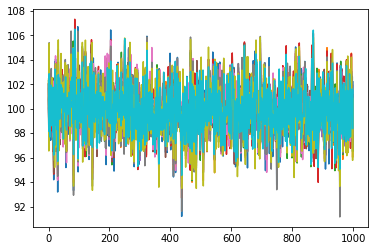

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import random

# Problem set up
N = 1000
n = 10

# Generate n-dimensional N iid vector-samples from a Gaussian pdf
# Random variables will have zero mean and a symmetric PD covariance matrix
# generated from a randomly selected matrix A
A = np.random.rand(n, n)
# Not necessary, just illustrating symmetry property
Sigma = A.dot(A.T) 
# Arbitrary mean of 100 for all dimensions
mu = np.full((n, 1), 100)

# Generate N random variables of length n
X = A.dot(np.random.randn(n, N)) + mu.dot(np.ones((1, N)))
X = X.T  # observations along rows, features along columns (N x n)
plt.plot(X)

Basic idea of PCA is to find a <b>linear</b> and <b>orthogonal</b> projection of a high-dimensional $\mathbf{x} \in {\mathbb{R}}^{n}$ to a low-dimensional <b>latent vector</b> $\mathbf{z} \in {\mathbb{R}}^{m}$, where $d \ll n$, such that $\mathbf{z}$ accurately represents the original data. We can acquire this "hidden" vector via a linear projection onto the latent space: $\mathbf{z} = \mathbf{W}^\intercal\mathbf{x}$, where $\mathbf{W}$ is an orthogonal projection matrix.

We could then define how well $\mathbf{z} = \mathbf{W}^\intercal(\mathbf{x} - \mu_{\mathbf{x}})$  "represents"  $\mathbf{x}$ based on the <b>reconstruction error</b>, usually defined by MSE, against a reconstruction/decoding $\mathbf{\hat{x}}= \mathbf{W}(\mathbf{z} + \mu_{\mathbf{x}}$). The mean here is written to illustrate how non-zero mean inputs would be centered.

From class, you know that minimizing the reconstruction error is equivalent to maximizing the variance of the projected data, when the inputs are mean-centered. You also know that the directions of maximal variance in the data are the eigenvectors of its covariance matrix $\Sigma$. Given this setup, let's first "encode" example $\mathbf{x}^{(i)}$ into a latent space of dimensionality $m$ with minimal reconstruction error as follows:

$$ \mathbf{z}^{(i)} = \mathbf{U}_m^\intercal \mathbf{x}^{(i)}, $$

where the optimal orthogonal projection matrix is $\mathbf{W^*} = \mathbf{U}_m$, with the columns of $\mathbf{U}_m$ as the $m$ eigenvectors of $\mathbf{\Sigma}$ with largest eigenvalues:

$$ \mathbf{\Sigma} = \mathbf{U}_m \mathbf{\Lambda} \mathbf{U}_m^\intercal , $$

with $\mathbf{\Lambda} = \text{diag}(\lambda_1, \ldots, \lambda_m)$, $\lambda_1 > \cdots > \lambda_m$ sorted in decreasing order of value.

Stacked into matrix form for all $N$ examples:

$$ \mathbf{Z} = \mathbf{X}\mathbf{U}_m .$$

From these $m$-dimensional principal component projections, we can reconstruct the original data approximately as follows:

$$\mathbf{\hat{x}}^{(i)} = \mathbf{U}_m \mathbf{z}^{(i)} , $$

which again in matrix form is:

$$ \mathbf{\hat{X}} = \mathbf{Z}_m \mathbf{U}_m^\intercal .$$

There you have your minimized error reconstructions!

## Problem Prompt

Let's explore the following relations against the number of PC components $m$:
- The reconstruction loss
$$ \text{MSE}_m = \frac{1}{N} \sum_{i=1}^N \|\mathbf{x}^{(i)} - \mathbf{U}_m \mathbf{z}^{(i)}\|_2^2 $$
- The fraction of variance "explained" or cumulative explained variance
$$ \text{F}_m = \frac{\text{Variance Retained by PC Components}}{\text{Total Variance in Data}} = \frac{\sum_{j=1}^m \lambda_j}{\text{tr}(\mathbf{\Sigma})} \in [0, 1] $$

Now evaluate the reconstruction loss over and fraction of variance explained by plotting for $m \in \{1, \ldots, n-1\}$ components, i.e. plots for $\text{MSE}_m$ vs $m$ and $\text{F}_m$ vs $m$. Note I will actually demonstrate reconstruction loss based on Root MSE (RMSE) so as to display values in the same order as our inputs.

Acquire the PCs:

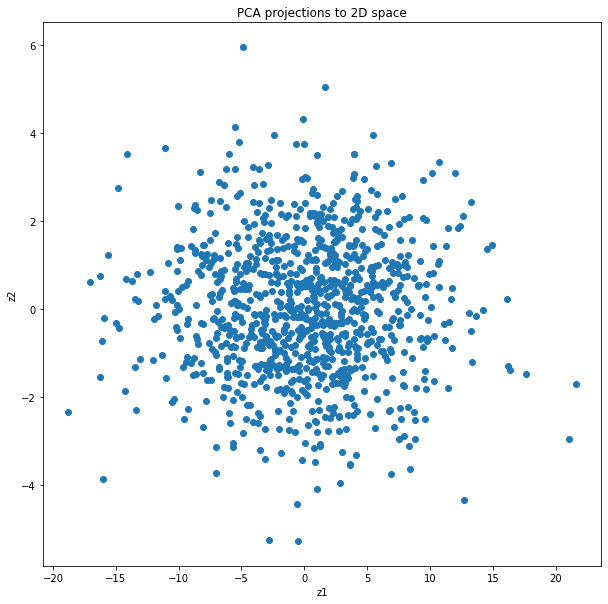

In [2]:
# First derive sample-based estimates of mean vector and covariance matrix:
mu_hat = np.mean(X, axis=0)
Sigma_hat = np.cov(X.T)

# Mean-subtraction is a necessary assumption for PCA, so perform this to obtain zero-mean sample set
C = X - mu_hat

# Get the eigenvectors (in U) and eigenvalues (in D) of the estimated covariance matrix
lambdas, U = np.linalg.eig(Sigma_hat)
# Get the indices from sorting lambdas in order of increasing value, with ::-1 slicing to then reverse order
idx = lambdas.argsort()[::-1]
# Extract corresponding sorted eigenvectors and eigenvalues
U = U[:, idx]
D = np.diag(lambdas[idx])

# Calculate the PC projections of zero-mean samples (in z)
Z = C.dot(U)

# Let's see what it looks like only along the first two PCs
fig = plt.figure(figsize=(10, 10))
plt.scatter(Z[:, 0], Z[:, 1])
plt.xlabel("z1")
plt.ylabel("z2")
plt.title("PCA projections to 2D space".format(n))
plt.show()

Now reconstruct the data $\mathbf{\hat{X}}$ from the projection matrix with PC component directions as its column vectors $\mathbf{Z} \in \mathbb{R}^{N \times m}$, where $m \in \{1, \ldots, n-1\}$.

In [3]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

# Max number of PCs based on rank of X, or min(n, N)
X_rank = np.linalg.matrix_rank(X)

rmse = np.zeros(X_rank)
sum_eigenvals = np.zeros(X_rank)
no_components = range(1, X_rank + 1)

# Reconstruct the X data set from each set of projections
for m in no_components:
    # Reconstruct based on only the 'm' components (also revert mean-centering effect)
    X_hat = Z[:, :m].dot(U[:, :m].T) + mu_hat
    rmse[m-1] = np.sqrt(np.mean((X - X_hat)**2))
    sum_eigenvals[m-1] = np.sum(D[:m])
    
# Fraction of variance explained
fraction_var = sum_eigenvals / np.trace(Sigma_hat)

Now plot and refer to Chpt. 20.1.4 of Murphy's 2022 book for further understanding!

Text(0, 0.5, 'Fraction of Variance Explained')

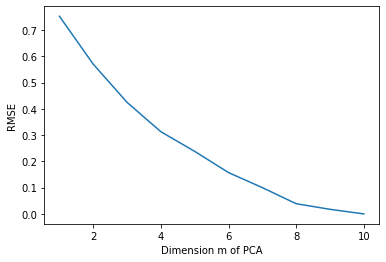

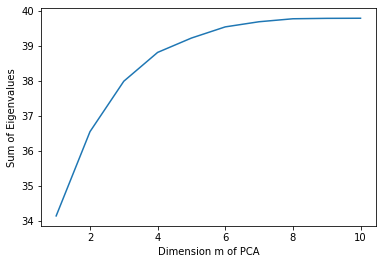

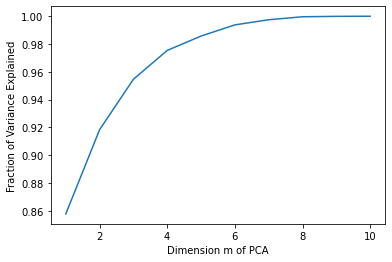

In [4]:
# MSE should be decreasing on each iteration, 0 for the nth
plt.figure(0)
plt.plot(no_components, rmse)
plt.xlabel("Dimension m of PCA")
plt.ylabel("RMSE")

# First eigenvalue should be significantly larger than the rest
plt.figure(1)
plt.plot(no_components, sum_eigenvals)
plt.xlabel("Dimension m of PCA")
plt.ylabel("Sum of Eigenvalues")

# About 95% variance explined is an acceptable target 
plt.figure(2)
plt.plot(no_components, fraction_var)
plt.xlabel("Dimension m of PCA")
plt.ylabel("Fraction of Variance Explained")